<a href="https://colab.research.google.com/github/AnaGutson/Organizacion-de-datos/blob/main/%C3%81rboles_Ana_Gutson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General**

Todo está escrito con un ejemplo, para mostrar una forma de realizar cada cosa.

## Carga de dataset a la notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ds_titanic = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titanic.csv')
ds_trabajo = ds_titanic.copy()

## Código para realizar predicción genérica


In [ ]:
#Se eliminan variables que no sirven
columnas_eliminar=['PassengerId','Name',"Ticket"]
ds_trabajo.drop(columnas_eliminar, axis='columns', inplace=True)  #Elimina columna sobre el mismo dataframe

#Se eliminan datos faltantes
columnas_eliminar_NANs=['Cabin']
ds_trabajo.drop(columnas_eliminar_NANs, axis='columns', inplace=True)
ds_trabajo=ds_trabajo.dropna()

#Se obtienen los sets de entrenamiento y test
ds_trabajo_x = ds_trabajo.drop(['Survived'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo['Survived'].copy()
x_train, x_test, y_train, y_test = train_test_split(	ds_trabajo_x, 
                                                      ds_trabajo_y, 
	                                   		              test_size = 0.3,    		#30% al conjunto de test
	                                                  	random_state = 13, 	    #para poder reproducir el experimento
                  	                                	stratify=ds_trabajo_y)  #estratificado para mantener proporcion

#Se calcula el porcentaje de datos, tanto de entrenamiento como de test
pd.Series(y_train).value_counts(normalize=True)[1]*100
pd.Series(y_test).value_counts(normalize=True)[1]*100

#Se escalan los datos de entrenamiento con MinMaxScaler()
scaler = MinMaxScaler() 
scaler.fit(pd.DataFrame(x_train['Age']))
x_train['Age']=scaler.transform(x_train['Age'].to_frame())
x_test['Age']=scaler.transform(x_test['Age'].to_frame())

#Se entrena el modelo
model = #modelo
model.fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)

#Se crea un dataset nuevo para visualizarlo
ds_resultados = pd.DataFrame(zip(y_test, y_pred), columns=['test', 'pred'])
ds_resultados.head()

#Se puede visualizar en una matriz de confusion
tabla=confusion_matrix(ds_resultados['test'], ds_resultados['pred'])
grf=sns.heatmap(tabla,annot=True)
plt.show()

#Se pueden calcular las metricas
accuracy=accuracy_score(ds_resultados['test'], ds_resultados['pred'], normalize=True)
recall=recall_score(ds_resultados['test'], ds_resultados['pred'])
f1=f1_score(ds_resultados['test'], ds_resultados['pred'])

## **Búsqueda de hiperparámetros**

Se busca construir el "mejor" clasificador eligiendo los hiperparametros más adecuados mediante validación cruzada.

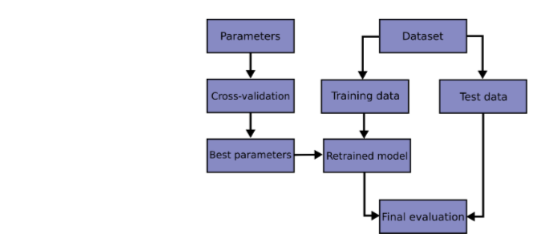

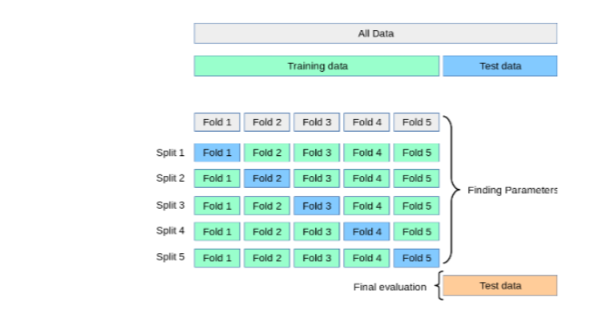

Para encontrar la mejor combinación de hiperparámetros, se explora un espacio de búsqueda, usando k-fold CV para medir el desempeño de cada combinación. Al terminar, se elige la combinación con mejor desempeño y se entrena un único modelo usando todos los datos de train.

Las exploraciones pueden ser:
- **Random Search**: explorar opciones y combinaciones al azar.
- **Grid Search**: se plantean y exploran todas las combinaciones.

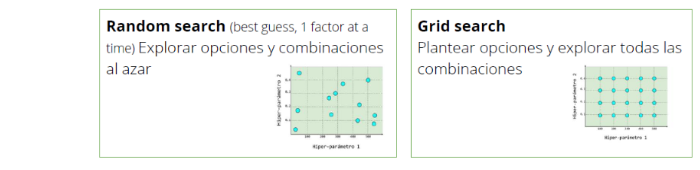

### Ejemplos


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('always')
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer

#### Random Search con árbol

In [ ]:
#Cantidad de combinaciones que se quiere probar
n=20 

#Conjunto de parámetros que se quiere usar
params_grid = {'criterion': ['gini','entropy'],
               #'min_samples_leaf': list(range(1, 10)),
		           #'min_samples_split': list(range(2, 20)),
	             'ccp_alpha': np.linspace(0, 0.05, n), 
               'max_depth': list(range(1, 10))}

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits = folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_iter = n) 

#Busco los hiperparametros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#Mejores hiperparametros del árbol
randomcv.best_params_

#Mejor métrica
randomcv.best_score_

#Todas las métricas obtenidas
randomcv.cv_results_['mean_test_score']

#Atributos considerados y su importancia
best_tree = randomcv.best_estimator_
feat_imps = best_tree.feature_importances_
sorted(zip(feat_imps,ds_trabajo_x.columns.values))

#Me quedo con los mejores hiperparametros: opcion 1
tree_cv_best=gs_fit.best_estimator_
y_pred_tree_cv_best = tree_cv_best.predict(x_test)

#Me quedo con los mejores hiperparametros: opcion 2
params_elegidos=gs_fit.cv_results_['params'][np.argmax(gs_multimetrica_fit.cv_results_['mean_test_roc_auc'])]
base_tree = DecisionTreeClassifier(	criterion = params_elegidos['criterion'], 
              		 		ccp_alpha =   params_elegidos['ccp_alpha'],
               				max_depth =   params_elegidos['max_depth']	)
model = base_tree .fit(X = x_train, y = y_train)
y_pred_cv_best = model.predict(x_test)

#### Grid Search con árbol

In [ ]:
#Se crea un clasificador vacío
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = {"criterion" : ["gini", "entropy"],
              "min_samples_leaf" : [1, 5, 10],
              "max_features":["sqrt", "log2"],
              "min_samples_split" : [2, 4, 10],
              "n_estimators": [10,20, 50] }

#Se prueba entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

#Se entrena un modelo con la mejor combinacion de hiperparametros
gs_fit = gs.fit(X = x_train, y = y_train)
params_elegidos = gs_fit.cv_results_['params'][np.argmax(gs_fit.cv_results_['mean_test_roc_auc'])]
rfc = RandomForestClassifier(	criterion= params_elegidos['criterion'], 
			min_samples_leaf= params_elegidos['min_samples_leaf'], 
			min_samples_split= params_elegidos['min_samples_split'], 
			n_estimators=params_elegidos['n_estimators'], 
			max_features=params_elegidos["max_features"],
			random_state=2, n_jobs=-1)
model_rfc= rfc.fit(X = x_train, y = y_train)
y_pred_model_rfc = model_rfc.predict(x_test)

# **Árboles**

## **ID3**

Soporta:
- Variables cualitativas, discretas.

No soporta:

- Conjuntos numéricos, rangos continuos.
- Datos faltantes.


## **C4.5**


$\rightarrow$ Mejora de ID3.

Soporta:
- Mayor conjunto de datos.
- Conjuntos numéricos, rangos continuos.
- Datos faltantes.






**Datos Faltantes**

Los marca con “?” y no se usan en los cálculos de ganancia y entropía.


**Campos numéricos o campos continuos**

Se parte el conjunto en dos grupos, y se trabajan como booleanos (“True” o “false”).

Para encontrar el umbral (donde se parte el conjunto), se busca tal que se tenga la mayor ganancia de información.

> **Pasos**
- Se ordena el conjunto, por ejemplo de menor a mayor.
- Se identifican los valores adyacentes (de la clase que es la salida).
- Se detecta cuando hay un cambio de valor de salida, entonces en esos límites seguramente están los umbrales candidatos. 
- Se crean varios umbrales candidatos, que dividen en dos el rango. Para cada uno de estos rangos se calcula la ganancia de información.
- El umbral resultante es el que da el mejor resultado (se puede también quedar con los N mejores).

**Poda**

Se cortan las ramas que no aportan información.

$\rightarrow$ Permite que queden árboles más simples.

> Pasos:
- Se genera el árbol.
- Se analiza recursivamente, desde las hojas, qué preguntas (nodos interiores) se pueden eliminar sin que se incremente el error de clasificación con el conjunto de test.
- Si hay ruido (problemas con la información original), el árbol tendrá un error, es decir, cantidad de casos mal clasificados. \\
Error = casos bien clasificados/casos totales (es decir, la precisión).
- **Eliminación**
  - Se elimina un nodo interior cuyos sucesores son todos nodos hoja.
  - Se vuelve a calcular el error que se comete con este nuevo árbol sobre el conjunto de test.
  - Si este error es menor que el error anterior, entonces se elimina el nodo y todos sus sucesores (hojas).
  - Se repite.


## **Random Forest**


$\rightarrow$ Para grandes volúmenes de datos.

Muchos estimadores mediocres, promediados pueden ser muy buenos.

Son árboles $C4.5$.


### **Bootstrap aggregating**

Técnica o meta-algoritmo.

Dado un conjunto de entrenamiento $D$, de tamaño $n$, la técnica de bagging generará $m$ nuevos conjuntos de entrenamiento $D_1, \dots, D_i, \dots, D_m$, cada uno de tamaño $n’$, tomando muestras aleatorias de $D$. En general, $n’ < n$, siendo $n’$ aproximadamente $\frac23 n$.

> **Pasos**
- Se arman $m$ subtablas, cada una con $n’ = \frac23 n$ filas.
- **Attribute bagging (o random subspace)**: Para cada una de las $m$ tablas, se escogen $√(n° \space de \space atributos)$, redondeado, aleatoriamente.
-Con cada una de las $m$ tablas, reducidas en atributos, se entrena un árbol.
-Para cada árbol se calcula:
  - su matriz de confusión.
  - su tasa de error $= \frac{(\textrm{falsos positivos} + \textrm{falsos negativos})}{total}$.
- Se elige el mejor arbol de los $m$, y se repite el proceso $k$ veces (la idea es que cada vez sea con distintas columnas).
- Al final se tendrán $k$ árboles.
- Para clasificar un nuevo ejemplo, se ejecuta el caso para cada uno de los $k$ árboles.
- Nos quedamos con la categoría elegida por la mayoría de los árboles.



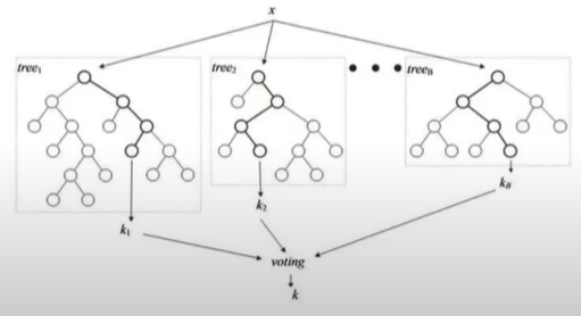

### Ejemplo

Se tiene un conjunto de datos de:
- $8$ atributos.
- clases.
- $9000$ registros.

Y se quiere conocer una clase.

Se hacen $m$ subtablas, cada una con $6000$ filas ($\frac23$ del total).
Para cada una de las tablas, se escogen $3$ $(round(√8))$ columnas de forma aleatoria.


### Código

Pasos:

- Se crea un modelo de árbol:
- Se informa:
  - max_features: la cantidad de atributos que va viendo cada nodo.
  - n_estimators: la cantidad de árboles.
  - criterion: entropía o gini.
  - min_samples_leaf: el mínimo de casos de cada hoja.
  - min_samples_split: el mínimo para dividir esa hoja.


**Clasificador**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Si tengo variables categóricas hago pd.get:dummies()

#Se obtienen los sets de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size=0.3, random_state=2)

#Se entrena el modelo
rfc = RandomForestClassifier(max_features='auto',random_state=2, n_jobs=-1, n_estimators=50,
			criterion="entropy", min_samples_leaf=5,min_samples_split=5 )
model = rfc .fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)

#Importancia de los atributos
sorted(list(zip(ds_trabajo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

#Veo alguno de los arboles
estimator = model.estimators_[1]
plt.figure(figsize=(100,100))
arbol_unico = tree.plot_tree(estimator, max_depth=2, feature_names=ds_trabajo_x.columns.to_list(), filled=True, rounded=True)
plt.show(arbol_unico)

**Regresor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Si tengo variables categóricas hago pd.get:dummies()

#Se obtienen los sets de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size=0.3, random_state=2)

#Se entrena el modelo
rfr = RandomForestRegressor( max_features='sqrt', random_state=2, n_jobs=-1,
	             		  criterion="squared_error", min_samples_leaf=5,
			  min_samples_split=5, n_estimators=50 )
model = rfr.fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)


## **Código general para crear un árbol**


En general, normalizar no genera ningún beneficio.

Pasos:

- Se crea un modelo de árbol:
  - Se informa:
    - criterion: entropía o gini.
    - max_depth: la profundidad máxima.
    - min_samples_leaf: el mínimo de casos de cada hoja.
    - ccp_alpha: el coeficiente de complejidad
  $ \rightarrow $ Esto es para podar el arbol.
- Se entrena el modelo con los datos de entrenamiento.
- Se puede graficar el árbol obtenido.
  - Si se grafica el arbol con los nodos, cada nodo va a tener información de:
    - La condición para ir a una hoja u a otra.
    - El valor de la entropía.
    - La cantidad de filas con la que entrenó.
    - Cuántas de esas filas van para cada lado (hoja izquierda u hoja derecha).
  - Es recomendable detener el crecimiento con restricciones para que no se pegue completamente a los datos, que los nodos hoja sean puros y clasifique bien.
- Se puede obtener la importancia de los atributos.




In [ ]:
import pandas as pd
import numpy as np
!pip install dtreeviz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.preprocessing import MinMaxScaler
import dtreeviz.trees as dtreeviz
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#…

#Si tengo variables categóricas hago pd.get:dummies()

#Se obtienen los sets de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, ds_trabajo_y, test_size=0.3, random_state=2)

#Se entrena el modelo
tree_model = tree.DecisionTreeClassifier(criterion="entropy",max_depth = 20, min_samples_leaf=10) #criterion="gini",
#arbol_poda = tree.DecisionTreeClassifier(criterion="entropy",max_depth = 20, min_samples_leaf=10, ccp_alpha=0.01)
model = tree_model.fit(X = x_train, y = y_train)

#Se hace la prediccion
y_pred = model.predict(x_test)

#Se grafica el árbol - Forma 1
reglas = export_text(tree_model, feature_names=list(ds_trabajo_x.columns.to_list())
print(reglas)

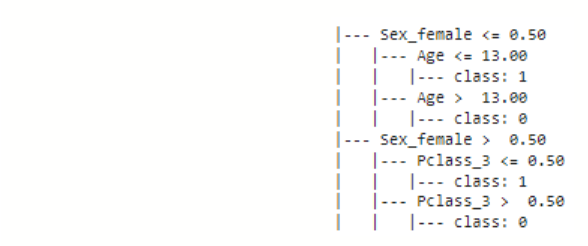

In [ ]:
#Se grafica el árbol - Forma 2
plt.figure(figsize=(100,100))
tree_plot_completo=tree.plot_tree(model,feature_names=ds_trabajo.columns.to_list(),filled=True,rounded=True)
plt.show(tree_plot_completo)

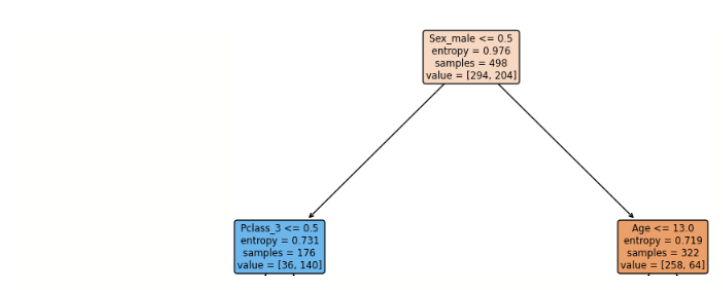

In [ ]:
#Se grafica el árbol - Forma 3
dot_data = StringIO()
export_graphviz(tree_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=ds_trabajo_x.columns.to_list(),
                class_names=['benign','malignant'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

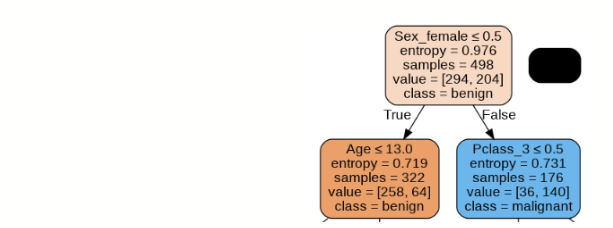

In [ ]:
#Se grafica el árbol - Forma 4
viz = dtreeviz.dtreeviz(
    model,
    ds_trabajo_x,
    ds_trabajo_y,
    target_name='Survived',
    feature_names=ds_trabajo_x.columns.to_list(),
    scale=1.5
)
display(viz)

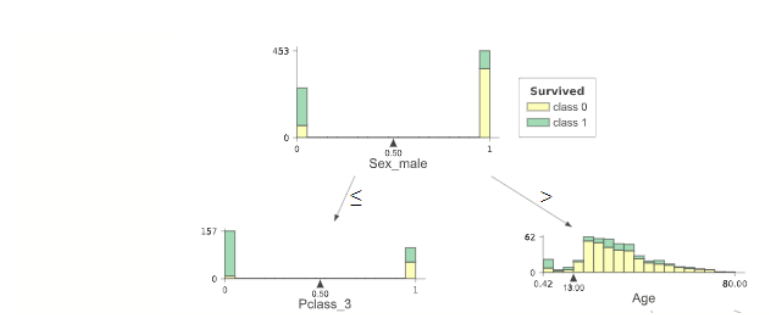

In [ ]:
#Importancia de los atributos
sorted(list(zip(ds_trabajo_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])